<a href="https://colab.research.google.com/github/sauravrox/image-text-detection/blob/main/Text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import csv
import gzip
import collections
import re
import io
import json
import xml.etree.ElementTree as ET

import requests
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
xml_path = os.path.join('/content/drive/MyDrive/image/drugbank.xml.gz')
with gzip.open(xml_path) as xml_file:
    tree = ET.parse(xml_file)
root = tree.getroot()

In [ ]:
ns = '{http://www.drugbank.ca}'
inchikey_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChIKey']/{ns}value"
inchi_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChI']/{ns}value"

rows = list()
for i, drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['description'] = drug.findtext(ns + "description")
    row['groups'] = [group.text for group in
        drug.findall("{ns}groups/{ns}group".format(ns = ns))]
    row['atc_codes'] = [code.get('code') for code in
        drug.findall("{ns}atc-codes/{ns}atc-code".format(ns = ns))]
    row['categories'] = [x.findtext(ns + 'category') for x in
        drug.findall("{ns}categories/{ns}category".format(ns = ns))]
    row['inchi'] = drug.findtext(inchi_template.format(ns = ns))
    row['inchikey'] = drug.findtext(inchikey_template.format(ns = ns))
    
    # Add drug aliases
    aliases = {
        elem.text for elem in 
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}synonyms/{ns}synonym[@language='English']".format(ns = ns)) +
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}products/{ns}product/{ns}name".format(ns = ns))

    }
    aliases.add(row['name'])
    row['aliases'] = sorted(aliases)

    rows.append(row)

In [ ]:
alias_dict = {row['drugbank_id']: row['aliases'] for row in rows}
with open('/content/drive/MyDrive/image/aliases.json', 'w') as fp:
    json.dump(alias_dict, fp, indent=2, sort_keys=True)

In [ ]:
def collapse_list_values(row):
    for key, value in row.items():
        if isinstance(value, list):
            row[key] = '|'.join(value)
    return row

rows = list(map(collapse_list_values, rows))
columns = ['name','description']
df1 = pd.DataFrame.from_dict(rows)[columns]
df1.head()

,name,description
0,Lepirudin,Lepirudin is identical to natural hirudin exce...
1,Cetuximab,Epidermal growth factor receptor binding FAB. ...
2,Dornase alfa,Dornase alfa is a biosynthetic form of human d...
3,Denileukin diftitox,A recombinant DNA-derived cytotoxic protein co...
4,Etanercept,Dimeric fusion protein consisting of the extra...


In [ ]:
df2=pd.read_csv('/content/drive/MyDrive/image/drugsComTrain_raw.csv')
frames = [df1, df2]
result = pd.concat(frames)
result.shape

(169056, 2)

In [ ]:
!pip install tesseract-ocr
!pip install libtesseract-dev
!pip install pytesseract

  Using cached tesseract-ocr-0.0.1.tar.gz (33 kB)
  ERROR: Failed building wheel for tesseract-ocr
  Running setup.py clean for tesseract-ocr
Failed to build tesseract-ocr
    Running setup.py install for tesseract-ocr ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-7n5e45bm/tesseract-ocr_931d012530334f169fd0b2ed080eeb65/setup.py'"'"'; __file__='"'"'/tmp/pip-install-7n5e45bm/tesseract-ocr_931d012530334f169fd0b2ed080eeb65/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-xo_l8cpa/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/tesseract-ocr Check the logs for full

In [ ]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
custom_config = r' — oem 3 — psm 6'
from matplotlib import pyplot as plt

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 c

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
import os, sys, subprocess
if "google.colab" in sys.modules:
    cmd = "pip install --upgrade watermark"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

In [ ]:
from PIL import ImageFont, ImageDraw, Image
import os
filepath = '/content/drive/MyDrive/image/images.jpg'
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height

def find_font_size(text, font, image, target_width_ratio):
    tested_font_size = 100
    tested_font = ImageFont.truetype(font, tested_font_size)
    observed_width, observed_height = get_text_size(text, image, tested_font)
    if(observed_width>0):
      estimated_font_size = tested_font_size / (observed_width / width) * target_width_ratio
      return round(estimated_font_size)

def get_text_size(text, image, font):
    im = Image.new('RGB', (width, height))
    draw = ImageDraw.Draw(im)
    return draw.textsize(text, font)

width_ratio = 0.5
font_family = os.path.join("/content/drive/MyDrive/image/arial.ttf")

In [ ]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [ ]:
# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def image_smoothening(img):
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return image_sharp

def remove_noise_and_smooth(img):
    # img = cv2.imread(file_name, 0)
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 41)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

In [ ]:
from PIL import ImageFilter, ImageEnhance
from PIL import ImageChops, Image

from scipy import misc, ndimage

In [ ]:
import imutils

image = Image.open(filepath)

greyscale_image = image.convert('L')
greyscale_image.save(filepath)

Image.open(filepath)

print(image.mode) # Output: RGB
print(greyscale_image.mode) # Output: L

L
L


In [ ]:
contrast = ImageEnhance.Contrast(image)
contrast.enhance(3.0).save('photo.jpg')

In [ ]:
brightness = ImageEnhance.Brightness(image)
brightness.enhance(3.0).save('photo.jpg')

In [ ]:
sharpness = ImageEnhance.Sharpness(image)
sharpness.enhance(3.0).save('photo.jpg')

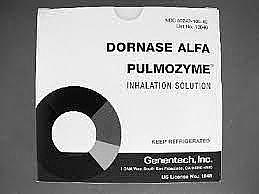

In [ ]:
Image.open('photo.jpg')

In [ ]:
# Get OCR output using Pytesseract
custom_config = r'--oem 3 --psm 6'
str1 = pytesseract.image_to_string(image, lang="eng", config="--psm 6")

In [ ]:
file1 = open('myfile.txt', 'w')
file1.writelines(str1)
file1.close()

In [ ]:
# Using readlines()
file1 = open('myfile.txt', 'r')
Lines = file1.readlines()

In [ ]:
print(Lines)
for line in Lines:
  line = line.strip()
  if line!='':
    line = re.sub('[^A-Za-z0-9]+', ' ', line)
    # pg = result[result['name'].str.contains(line, case=False)]
    pg = result[result['name'].str.contains(line, case=False)]
    print(pg)      

['DORNASE ALFA\n', 'PULMOZYME:\n', 'ImaLaion seuvron\n', '\n', 'Se\n', '\x0c']
                name                                        description
2       Dornase alfa  Dornase alfa is a biosynthetic form of human d...
143235  Dornase alfa                                    Cystic Fibrosis
Empty DataFrame
Columns: [name, description]
Index: []
Empty DataFrame
Columns: [name, description]
Index: []
                name                                        description
2       Dornase alfa  Dornase alfa is a biosynthetic form of human d...
8          Alteplase  Human tissue plasminogen activator, purified, ...
9         Sermorelin  Sermorelin acetate is the acetate salt of an a...
12         Urokinase  Low molecular weight form of human urokinase, ...
13         Goserelin  Goserelin is a synthetic hormone. In men, it s...
...              ...                                                ...
161147    Sertraline                             Social Anxiety Disorde
161209      Seroque

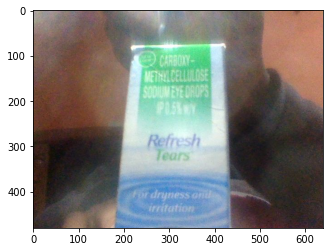

In [ ]:
plt.imshow(image)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/image/letters.csv')
df2 = pd.read_csv('/content/drive/MyDrive/image/letters2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/image/letters3.csv')

In [ ]:
frames = [df1, df2, df3]
df = pd.concat(frames)
df.shape

(14190, 4)

In [ ]:
df = df1

In [3]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from tqdm import tqdm


In [4]:
# Remove warning messages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

# navigation and read files
import glob
import os

# Read HDF5 binary data format: convenient for large data storage
import h5py

# Read and display images
import matplotlib.pyplot as plt
import imageio
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow import keras

# DL dependancies
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [5]:
# Path of images
PATH_TO_DATA = '/content/drive/MyDrive/image/'
CSV_FILES =  ['letters.csv', 'letters2.csv', 'letters3.csv']

In [6]:
def import_data(CSV_FILE):
    data = pd.read_csv(PATH_TO_DATA + CSV_FILE)
    # Create path extention for corresponding folders that contains images 
    data['source'] = CSV_FILE[:-4]+'/'
    return data

In [7]:
data1 = import_data(CSV_FILES[0])
data2 = import_data(CSV_FILES[1])
data3 = import_data(CSV_FILES[2])
data = pd.concat([data1, data2, data3], ignore_index=True)

# I won't use these data anymore
del(data1, data2, data3)

In [8]:
data = shuffle(data, random_state = 42)

In [9]:
# Get all labels in one string
letters = '' 
for letter in data.letter.unique():
    letters += letter
    
# Which letter is written on each image
labels = data.label

In [10]:
def ohe_letters(label):
    '''
    One hot encoding for the target label
    '''
    resu = np.zeros(len(letters))
    index = letters.index(label)
    resu[index] = 1
    return resu

def ohe_backgrounds(label):
    '''
    One hot encoding for background column
    '''
    resu = np.zeros(len(data.background.unique()))
    resu[label] = 1
    return resu

In [11]:
data['encoded_letter'] = data['letter'].apply(lambda x:ohe_letters(x))
data['encoded_background'] = data['background'].apply(lambda x:ohe_backgrounds(x))

In [12]:
data

,letter,label,file,background,source,encoded_letter,encoded_background
6491,щ,27,27_212.png,2,letters2/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,03_53.png,2,letters2/,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,29_336.png,3,letters3/,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,19_311.png,3,letters3/,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,27_278.png,3,letters3/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
...,...,...,...,...,...,...,...
5191,т,20,20_172.png,2,letters2/,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13418,ь,30,30_259.png,3,letters3/,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
5390,у,21,21_191.png,2,letters2/,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
860,р,18,18_11.png,0,letters/,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0]"


In [13]:
# Store all png images into one numpy array
images = []
# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# I want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    numpy_image = cv2.imread(os.path.join(PATH_TO_DATA + row['source'], img_name))
    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['encoded_letter'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['encoded_background'])
        
# Normalize array of images
images = np.array(images)/255

In [14]:
def display_image(images_list, list_of_labels = np.arange(9)):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index in list_of_labels:
        
        # Get corresponding label
        ohe_label = encoded_labels[index]
        index_letter = list(ohe_label).index(1)
        associated_letter = letters[index_letter]

        # Get background
        associated_background = backgrounds[index]
        
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Label: %s \n'%associated_letter+\
                 'Background: %s\n'%associated_background,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(images[index])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()


In [15]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

In [16]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(letters)
# Group of training samples
BATCH_SIZE = 64
# Number of complete presentations of the dataset to be learned
EPOCHS = 100

In [17]:
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [18]:
def CNN_model(activation = 'softmax', 
              loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy', top_3_categorical_accuracy]):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))
    
    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer, 
                  metrics = metrics)
    
    return model

In [19]:
# Init CNN model
cnn_model = CNN_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = '/content/drive/MyDrive/image/weights.best.letters.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=2)

# Training
history = cnn_model.fit(X_train, y_train,
                        batch_size = BATCH_SIZE,
                        epochs = 1,
                        verbose = 1,
                        validation_data = (X_val, y_val),
                        callbacks = [checkpointer, lr_reduction, estopping])


178/178 [==============================] - ETA: 0s - loss: 3.4404 - accuracy: 0.0507 - top_3_categorical_accuracy: 0.1360
Epoch 1: val_loss improved from inf to 3.15397, saving model to /content/drive/MyDrive/image/weights.best.letters.hdf5
178/178 [==============================] - 172s 959ms/step - loss: 3.4404 - accuracy: 0.0507 - top_3_categorical_accuracy: 0.1360 - val_loss: 3.1540 - val_accuracy: 0.1477 - val_top_3_categorical_accuracy: 0.3145 - lr: 0.0010


In [20]:
dict_keys(['loss', 'accuracy', 'top_3_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_top_3_categorical_accuracy', 'lr'])

NameError: ignored

In [ ]:
plot_history(history)

In [21]:
# loading the model with the best validation accuracy
cnn_model.load_weights('/content/drive/MyDrive/image/weights.best.letters.hdf5')
cnn_model.evaluate(X_val, y_val)

89/89 [==============================] - 10s 109ms/step - loss: 3.1540 - accuracy: 0.1477 - top_3_categorical_accuracy: 0.3145


[3.153965950012207, 0.14774329960346222, 0.3145275115966797]

In [22]:
def load_image(path_filename):
	# load the image
	img = load_img(path_filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

In [23]:
def get_true_label(path_filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(path_filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]

In [30]:
img = load_image('/content/drive/MyDrive/image/letters/33_50.png')

In [33]:
# predict the class
# a_letter = cnn_model.predict_classes(img)
predict_x=cnn_model.predict(img) 
classes_x=np.argmax(predict_x,axis=1)
# print(classes_x)
# print(letters)
# plt.imshow(img[0])
print('predicted:', letters[classes_x[0]])
# print('true label:', get_true_label(PATH_TO_DATA+'letters3/01_235.png', data, 'letter'))

predicted: п


In [34]:
def load_random_images(number_of_images_to_load = 9):
    images = []
    true_labels = []
    true_backgrounds = []
    
    which_folder = [random.randint(1,3) for _ in range(number_of_images_to_load)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = PATH_TO_DATA+'letters/'
        else:
            path = PATH_TO_DATA+'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))
        
        index_image = random.randint(0, len(os.listdir(path)))
        
        image = load_image(path + os.listdir(path)[index_image])
        label = get_true_label(path + os.listdir(path)[index_image], data, 'letter')
        background = get_true_label(path + os.listdir(path)[index_image], data, 'background')

        images.append(image)
        true_labels.append(label)
        true_backgrounds.append(background)
        
    return images, true_labels, true_backgrounds


In [35]:
def classes_predictions(images_list_to_classify, true_labels, model):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):
        
        a_letter = model.predict_classes(image)
        associated_letter = letters[a_letter[0]]
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
        
    # show the figure
    plt.show()

In [36]:
test_images, true_labels, true_backgrounds = load_random_images()

In [37]:
classes_predictions(test_images, true_labels, cnn_model)
predict_x=cnn_model.predict(img) 
classes_x=np.argmax(predict_x,axis=1)

AttributeError: ignored

<Figure size 864x864 with 0 Axes>

In [38]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_backgrounds.copy())

In [39]:
# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

In [40]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(set(backgrounds))
# Group of training samples
BATCH_SIZE = 32
# Number of complete presentations of the dataset to be learned
EPOCHS = 100

In [41]:
def CNN_back_model(activation = 'softmax', 
              loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy', top_3_categorical_accuracy]):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))
    
    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer, 
                  metrics = metrics)
    
    return model

In [43]:
# Init CNN model
background_model = CNN_back_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = '/content/drive/MyDrive/image/weights.best.letters.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=2)

# Training
history_background = background_model.fit(X_train, y_train,
                                          batch_size = BATCH_SIZE,
                                          epochs = 1,
                                          verbose = 1,
                                          validation_data = (X_val, y_val),
                                          callbacks = [checkpointer, lr_reduction, estopping])


355/355 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7917 - top_3_categorical_accuracy: 0.9666
Epoch 1: val_loss improved from inf to 0.41593, saving model to /content/drive/MyDrive/image/weights.best.letters.hdf5
355/355 [==============================] - 182s 509ms/step - loss: 0.5659 - accuracy: 0.7917 - top_3_categorical_accuracy: 0.9666 - val_loss: 0.4159 - val_accuracy: 0.8604 - val_top_3_categorical_accuracy: 0.9817 - lr: 0.0010


In [ ]:
plot_history(history_background)

In [44]:
# loading the model with the best validation accuracy
background_model.load_weights('/content/drive/MyDrive/image/weights.best.letters.hdf5')
background_model.evaluate(X_val, y_val)

89/89 [==============================] - 10s 111ms/step - loss: 0.4159 - accuracy: 0.8604 - top_3_categorical_accuracy: 0.9817


[0.41592511534690857, 0.860366702079773, 0.9816642999649048]

In [52]:
def improved_classes_predictions(images_list_to_classify, true_labels, true_backgrounds, letter_model, backg_model):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):
        
        # a_letter = letter_model.predict_classes(image)
        # associated_letter = letters[a_letter[0]]
        
        a_letter=letter_model.predict(image) 
        classes_x=np.argmax(a_letter,axis=1)
        associated_letter = letters[classes_x[0]]

        # a_background_letter = background_model.predict_classes(image) 
        a_background_letter=background_model.predict(image) 
        classes_x=np.argmax(a_background_letter,axis=1)
        associated_letter = classes_x[0]


        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index]+\
                  'Predicted Background: %s\n'%a_background_letter[0]+\
                  'True Background: %s\n'%true_backgrounds[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
        
    # show the figure
    plt.show()


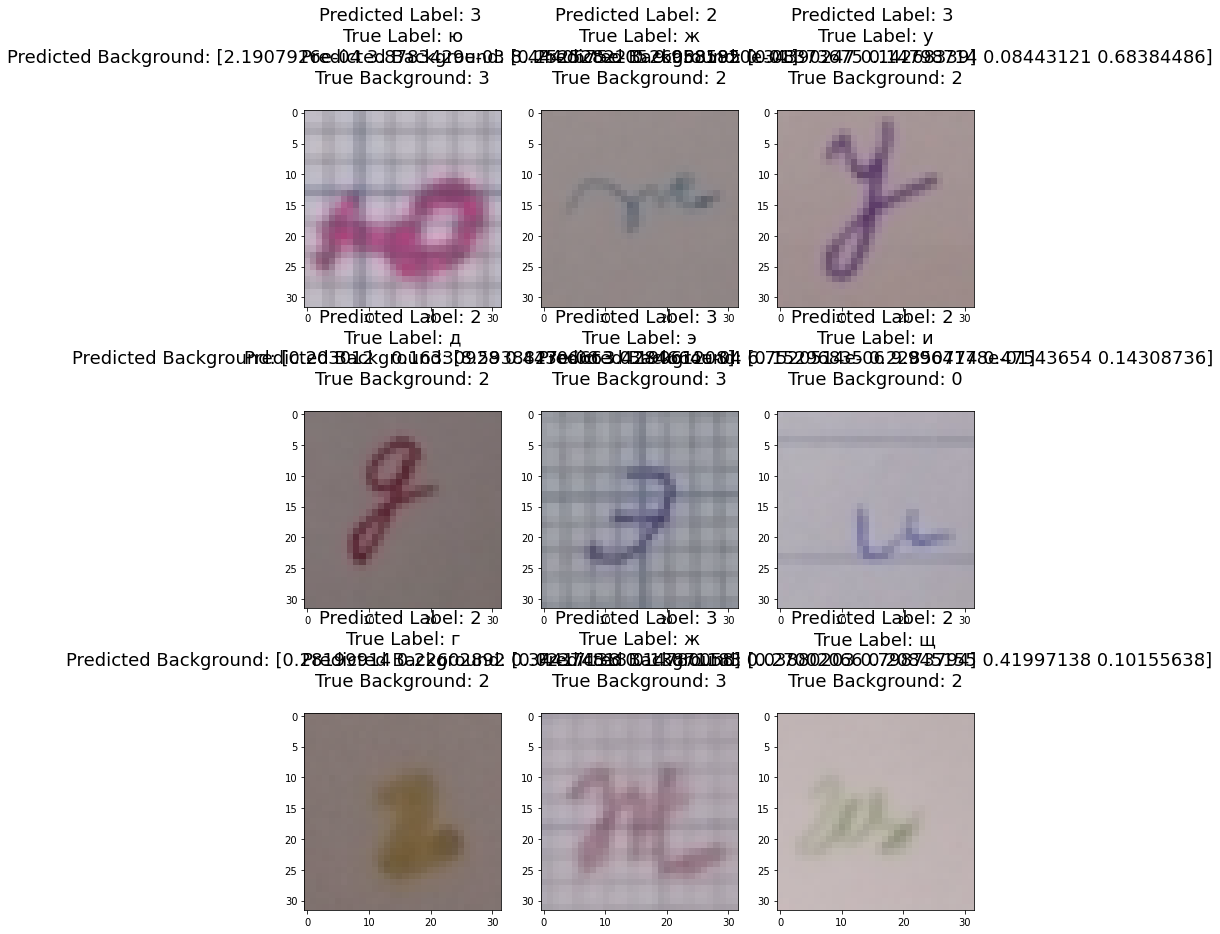

In [53]:
improved_classes_predictions(test_images, true_labels, true_backgrounds, cnn_model , background_model)